Things I want to add: 

dye/no time bin option (just laser on - laser off, average all) \
multiple detectors \
maybe weighted average options?  (I think I half did this so far) 

fix stack processed to output a dictionary!

# import

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import h5py
import sys
import os
import time
import scipy
import scipy.io as scio

from LCLSDataToolsNew.GeneralTools import *
from LCLSDataToolsNew.filterTools import *
from LCLSDataToolsNew.diffSignalTools import *
from LCLSDataToolsNew.plottingTools import *
from LCLSDataToolsNew.binningToolsErr import *
from LCLSDataToolsNew.anisotropyToolsAll import *
from LCLSDataToolsNew.SVDTools import *

from sklearn.linear_model import RANSACRegressor as RSC
from sklearn.linear_model import LinearRegression as LR

from LCLSDataToolsNew.SetUpFns import *
from LCLSDataToolsNew.DiffBinFns import *
from LCLSDataToolsNew.ReduceFns import *

# set up params dictionary

In [57]:
paramDict= {
        'binSetup'  : 'points',
        'binSet2'   : 300,
        'binMethod' : 'ave', 
        'qnorm'     : (3,4), 
        'qrange'    : (.2,4.5),
        'show_filters'  : True, #show filter plots
        'useAzav_std'  : False, 
        'azav_percent_filter' : None, # if nonzero, use azav_std as filter
        'ipm'    : 4, # select ipm to use
        'corr_filter' : True,
        'ipm_filter' : (5,None), # if corr_filter, can set limits for ipm intensity
        'I0_threshold'  : 1,
        'use_TT'   :   True,  #options are True, False, and 'filter'  ('filter is for filter only) 
        'scan_var' : None,
        'x_var'   : None,
        't0_corr' : None,  #false or float offset for time zero
        'enforce_iso': False,
        'NonLin_corr': None, #None, SVD, poly, or SVDbyBin
        'AdjSub'    : 50, #number of adjascent off shots to average and subtract, -1 subtracts all
        'aniso'  : True,
        'shift_n' :0,
        'xstat' : True,
    
    
        }

## can have defaults in config file and update parts of param dict here

# set up variable dictionary

In [3]:
varDict = {
        'ipm4'          : 'ipm4/sum',
        'ipm5'          : 'ipm5/sum',
        'xray_status'   : 'lightStatus/xray',
        'laser_status'  : 'lightStatus/laser',
        'ebeam_hv'      : 'ebeam/photon_energy',
        'scan_vec'      : 'scan/var0',
        'laser_diode'   : '/diodeGon/channels/',
    
        ## tt variables
        'ttCorr'        : 'tt/ttCorr',
        'ttAMPL'        : 'tt/AMPL',
        'ttFWHM'        : 'tt/FLTPOSFWHM',
        'ttFLTPOS'      : 'tt/FLTPOS',
        # 'ttFLTPOS_PS'   : 'tt/FLTPOS_PS', ## in picoseconds
        # 'ttREFAMPL'     : 'tt/REFAMPL',
        'encoder'       : 'enc/lasDelay',
        'lxt'           : 'epics/lxt' , 
        # 'lxt_ttc'       : 'epics/lxt_ttc',
        
        ## scattering variables
        'azav'      : 'epix10k2M/azav_azav',
        'qs'        : 'UserDataCfg/epix10k2M/azav__azav_q',
        'phis'      :  'UserDataCfg/epix10k2M/azav__azav_phiVec',
    
        ## scattering detector error
        #'azav_sqr'     :  'epix10k2M/azav_azav_square',
        # 'pix_per_azav'  :  'UserDataCfg/epix10k2M/azav__azav_norm',
    
        # ## spectroscopy variables
        # 'epix_roi0'        : 'epix_1/ROI_0_area',
        # 'epix_roi0_sum'    : 'epix_1/ROI_0_sum',
        # 'droplet_x'        : 'epix_1/ragged_droplet_photon_j', #nondispersive axis
        # 'droplet_y'        :  'epix_1/ragged_droplet_photon_i', #energy dispersive
        # 'epix_roi0_limits' : 'UserDataCfg/epix_1/ROI_0__ROI_0_ROI',

        }

# load data

In [4]:
def LoadH5(fname,varDict,paramDict,outDict):
    ''' load values designated in varDict from H5 file with name fname
    save data to outDict'''
    basename=fname.split('/')[-1].split('.')[0]
    outDict['h5name']=basename
    h5Dict={}
    with h5py.File(fname,'r') as d:
        for key in varDict:
            h5Dict[key]=d[varDict[key]][:]
        if paramDict['scan_var'] is None:
            try:
                if np.unique(h5Dict['scan_vec']).size > 1:
                    for scanvar in d['scan']:
                        paramDict['scan_var']=scanvar
                        break
                else:
                    paramDict['scan_var']='newdelay'

            except:               
                paramDict['scan_var']='newdelay'
            
    print('scan variable is ', paramDict['scan_var'])
    outDict['h5Dict']=h5Dict
    print('finished loading h5')

        

# calculate azav bin variation; filter on it 

In [5]:
def AzavStdFilter(paramDict,outDict):
    '''calculate Azav_Std from azav and azav_sqr fields of h5.  
    use parameter azav_percent_filter to reject azav bins where  azav_Std > perLim % is rejected
    '''
    
    azav_temp=outDict['h5Dict']['azav']
    azav_sqr=outDict['h5Dict']['azav_sqr']
    perFilt=paramDict['azav_percent_filter']
    
    azav_std=np.sqrt(np.abs(azav_sqr-(azav_temp)**2))
    
    # ## check if this is the formula we should be using
    # pix_per_bin=outDict['h5view']['pix_per_azav']
    # azav_std=np.sqrt(np.abs(azav_sqr/pix_per_bin-(azav_temp)**2))
    
    
    if perFilt is not None:
        ## remove noisy bins;  #error > perFilt % is rejected
        azav_per=np.nan_to_num(azav_std/azav_temp*100) #percent error
        azav_temp[azav_per>perFilt]=np.nan 
        azav_std[azav_per>perFilt]=np.nan
    
    outDict['h5Dict']['azav']=azav_temp
    outDict['h5Dict']['azav_std']=azav_std
    
    print('AzavStdFilt - done!')
    

# Mask bad azav bins

In [6]:
def MaskAzav(paramDict,outDict,listBinInd=None):
    ''' Mask specific azav bins and first/last two q bins for each phi 
    listBinInd = n x 2 array of phi,q indices for bin(s) you want to delete
    ex. [0,269]''' 
    print('masking azav bins')
    
    if paramDict['useAzav_std']=='WAve':
        keyList=['azav','azav_std']
    else:
        keyList=['azav']
        
    for key in keyList:
        azav_temp=outDict['h5Dict'][key]
        if listBinInd is not None:
            for ii in range(listBinInd.shape[0]):
                azav_temp[:,listBinInd[ii,0],listBinInd[ii,1]]=np.nan

        ind=np.nonzero(~np.isnan(azav_temp))
        iPhi=ind[1]
        iQ=ind[2]

        #for each phi bin replace first and last not-nan q bin with nan
        for i in range(azav_temp.shape[1]):
            ind2=np.nonzero(iPhi==i) #isolate this phi bin
            qind=iQ[ind2] #already sorted
            azav_temp[:,i,qind[[0,1,-2,-1]]]=np.nan
        
        outDict['h5Dict'][key]=azav_temp

    
    print('masking azav bins - done!')

# set up filters

In [7]:
def setupFilters(paramDict,outDict):
    ''' calculate I0 and set up laser on/off etc filters'''
    
    ## calculate I0 aka Isum (but actually average?) check this
    azav_temp=outDict['h5Dict']['azav']
    I0=np.nanmean(azav_temp,(1,2)) #mean along 2 axes
    outDict['I0']=I0
    print('calculated I0') 
    
    
    ### set up filters
    if 'filters' not in outDict.keys():
        outDict['filters']={}
    outDict['filters']['f_xon']=outDict['h5Dict']['xray_status']==1
    outDict['filters']['f_lon']=outDict['h5Dict']['laser_status']==1
    outDict['filters']['f_xoff']=outDict['h5Dict']['xray_status']==0
    outDict['filters']['f_loff']=outDict['h5Dict']['laser_status']==0 
    ## for later:
    outDict['filters']['f_lgood']=outDict['filters']['f_lon'] 
    outDict['filters']['f_good']= outDict['filters']['f_xon']
    print('setupFilters - done!')
    
    

# I0 filtering

In [8]:
def I0Filters(paramDict,outDict):
    '''
    if corr_filter then use ipm thresholds and I0/ipm correlation fit to filter
    histogram filter of I0 80%'''
    
    I0=outDict['I0']
    f_xon=outDict['filters']['f_xon']
    I0thresh=paramDict['I0_threshold']
    
        ##create filter on xray intensity keeping 80% of shots
    l,r,frac,f_I0=slice_histogram(I0,f_xon&(I0>I0thresh),0.80, 
                                      showplot=paramDict['show_filters'], fig='red', sub=221)
    outDict['filters']['f_I0']=f_I0
    outDict['filters']['f_good']=f_I0&f_xon ##formerly known as f_intens
    
    if paramDict['corr_filter']:
        print('making correlation filter')
        
        ##set ipm thresholds
        ipmkey='ipm'+str(paramDict['ipm'])
        ipmi=outDict['h5Dict'][ipmkey]
        ipmfilt=np.full_like(ipmi,1)
        if paramDict['ipm_filter'][0] != None:
            ipmfilt=np.logical_and((ipmfilt),(ipmi>paramDict['ipm_filter'][0]))
        if paramDict['ipm_filter'][1] != None:
            ipmfilt=np.logical_and((ipmfilt),(ipmi<paramDict['ipm_filter'][1]))
        
    
        ## correlation filter of ipm vs Isum
        thresh=10
        
        #RANSAC fit to line
        nanfilt=~np.isnan(I0)&~np.isnan(ipmi)&(ipmfilt)&(I0>I0thresh)
        ipm1=np.expand_dims(ipmi[nanfilt],axis=1)
        Isum1=I0[nanfilt]

        RSCthresh=10 #inlier/outlier threshold
        trialN=100 #number of RANSAC trials to preform
        trialsRSC=np.arange(trialN)
        outRSC=np.full((trialN,2),np.nan)
        for i in trialsRSC:
            #fit_intercept=False: y=mx
            reg=RSC(base_estimator=LR(fit_intercept=True), 
                    residual_threshold=thresh,max_trials=10000,is_data_valid=None).fit(ipm1,Isum1)

            outRSC[i,0]=reg.estimator_.coef_[0] #slope
            outRSC[i,1]=reg.estimator_.intercept_ #intercept 


        #find average slope 
        mm=np.nanmean(outRSC[:,0])
        bb=np.nanmean(outRSC[:,1]) 
        #find inliers
        resid=np.abs((mm*ipm1.squeeze()+bb)-Isum1.squeeze())
#                 in_mask=np.nonzero(resid<=thresh) #inliers
#                 out_mask=np.nonzero(resid>thresh) #outliers
        in_mask=resid<=thresh #inliers
        out_mask=resid>thresh #outliers
        line_y=ipm1[in_mask]*mm+bb
        print('correlation equation = %e x +%e' %(mm,bb))
        print('fraction of data kept %e' %(Isum1[in_mask].shape[0]/Isum1.shape[0]))
        f_corr=np.zeros(I0.shape).astype(bool)
#                 print(in_mask.shape)
#                 print(nanfilt.shape)
        f_corr[nanfilt]=in_mask
        outDict['filters']['f_corr']=f_corr
        outDict['filters']['f_good']=outDict['filters']['f_good'] & f_corr
                    
        ## plot
    if paramDict['show_filters']: 
        plt.figure('red')
        plt.subplot(2,2,2)
        if paramDict['corr_filter']:
            plt.scatter(ipm1[out_mask],Isum1[out_mask],marker='.',color='grey')
            plt.scatter(ipm1[in_mask],Isum1[in_mask],marker='.',color='black')
            plt.plot(ipm1[in_mask],line_y,color='r')
        else:
            nanfilt=~np.isnan(I0)&~np.isnan(ipmi)
            plt.hist2d(ipmi[nanfilt],I0[nanfilt],100,cmap='Greys',
                       norm=mpl.colors.SymLogNorm(linthresh=1, linscale=1))
            plt.xlabel(ipmkey)
            plt.ylabel('I0')
            plt.title('log of hist of shots')

# laser filter

In [9]:
def laserFilter(paramDict, outDict):
    ''' filter on laser intensity'''
    laserP= outDict['h5Dict']['laser_diode'][:,0]
    f_lon=outDict['filters']['f_lgood']
    
    #filter on the laser intensity
    
    # filterP = laserP>(np.nanmean(laserP)-np.nanstd(laserP)*3) 
    # l,r,frac,f_laser=slice_histogram(laserP,(f_lon&filterP),0.99)

    l,r,frac,f_laser=slice_histogram(laserP,(f_lon),0.99)
    
    outDict['filters']['f_laser']=f_laser
    outDict['filters']['f_lgood']=f_lon&f_laser
    print('filter on laser intensity -Done!')

# Ebeam filter

In [10]:
def eBeamFilter(paramDict,outDict):
    '''filter on x-ray photon energy/ebeam energy'''
    ebeam=outDict['h5Dict']['ebeam_hv']
    f_good=outDict['filters']['f_good']
    
    
    ## if fixed limits:
    # lower=17000
    # upper=17200
    # f_energ=(d['ebeam/photon_energy'][:]>lower)&(d['ebeam/photon_energy'][:]<upper) #necessary for the energy correction to be well-fit
    # frac=float(np.sum(f_energ))/float(len(f_energ))
    
    ##use slice histogram to keep 99% of shots
    l,r,frac,f_energ=slice_histogram(ebeam,f_good,
                                      0.99,showplot=False)
    
    outDict['filters']['f_eBeam']=f_energ
    outDict['filters']['f_good']=f_good&f_energ
    print('ebeam filter: fraction_kept ',frac,' lower ', l,' upper ',r)

# TT filters

In [11]:
## run this if (paramDict['useTT']==True) or (paramDict['useTT']=='filter'):

def TTfilter(paramDict,outDict):

    ttfwhm=outDict['h5Dict']['ttFWHM']
    ttpos=outDict['h5Dict']['ttFLTPOS']
    ttamp=outDict['h5Dict']['ttAMPL']
    showfilt=paramDict['show_filters']
    f_lon=outDict['filters']['f_lgood']
    f_good=outDict['filters']['f_good']

    ## filter on TT amplitude
    f_ttamp=( ttamp>0.01) #add this in if ttool seems suspect

    ##filter based on TT position
    l,r,frac,f_ttfwhm=slice_histogram(ttfwhm,
                                      f_lon&f_good&(ttfwhm>10)&(ttfwhm<300),
                                      0.99,showplot=showfilt,fig='red',sub=223)
    print('TTFWHM: fraction_kept ',frac,' lower ', l,' upper ',r)

    ## filter based on TT FWHM
    l,r,frac,f_ttpos=slice_histogram(ttpos,
                                      (f_good&f_ttamp&(ttpos>10)),
                                      0.99,showplot=showfilt,fig='red',sub=224)
    print('TTPOS: fraction_kept ',frac,' lower ', l,' upper ',r)

    ## save
    outDict['filters']['f_allTT']=f_ttpos&f_ttfwhm&f_ttamp
    outDict['filters']['f_lgood']=f_lon&f_ttpos&f_ttfwhm&f_ttamp
    outDict['filters']['f_good']=(outDict['filters']['f_good']&outDict['filters']['f_loff'])|(outDict['filters']['f_good']&outDict['filters']['f_lgood']) #want f_intens to cut on timetool as well




# set up X-axis (Scan axis)

In [12]:
def MakeScanAx(paramDict,outDict,tt_corrNew=None):
    ''' set up scan axis, use scanvariable or if time axis use time tool to calulate delays
    if tt_corrNew=None then use ttCorr from h5
    if ttcorrNew=(p1,p2) where p1,p2 are floats then calculate tt_corr with linear equation ttcorr = p1*fltpos + p2'''
    
    x_var=paramDict['x_var']
    scanvar=paramDict['scan_var']
    t0_corr=paramDict['t0_corr']
    use_tt=paramDict['use_TT']
    scanvec=outDict['h5Dict']['scan_vec']
    lxt=outDict['h5Dict']['lxt']
    enc=outDict['h5Dict']['encoder']
    ttCorr=outDict['h5Dict']['ttCorr']
    
    
    
    
    if x_var is None: # if no x specified, then use scan motor
        if scanvar=='newdelay': #or (scanvar=='lxt_ttc'):
            #we want time on the x-axis. two options:  ttool or no ttool:

            if t0_corr is None: #get additive correction for t0
                t0_corr=0.
            else:
                print('using provided t0_corr %f'%t0_corr)

            if (use_tt==False) or (use_tt=='filter'): # get delay info w/o time tool
                try:
                    x=t0_corr+lxt+enc*1e-12 # lxt plus encoder value is the time (seconds).
                    print('t = lxt+ (encoder)*1e-12')
                except KeyError:
                    try:
                        x=t0_corr+lxt
                        print('encoder unavailable, t = lxt')
                    except:
                        x=t0_corr+enc*1e-12
                        print('lxt unavailabe, t = (encoder)*1e-12')
            else: #want to use the timetool
                if tt_corrNew is not None:
                    ttCorr=tt_corrNew[0]*outDict['h5Dict']['ttFLTPOS']+tt_corrNew[1]

                x=t0_corr+(enc+ttCorr)*1e-12
                print('t=(encoder + tt/ttCorr)*1e-12')
                    
                    
        else: #any other scanvar besides time: just take the values from the array
            x=scanvec
            print('using scan_vector for binning axis')

    else: # want to bin along a non-scanned variable
        x=d[x_var][:]
        print('using x_var for binning axis')
        
    outDict['xs']=x

# enforce iso

In [13]:
def EnforceIso(paramDict,outDict):
    ''' enforce isotropic off shots'''
    f_loff=outDict['filters']['f_loff']
    f_intens=outDict['filters']['f_good']
    azav=outDict['h5Dict']['azav']
    Isum=outDict['I0']
    corr=np.array([0])
    if ((np.sum(corr)/corr.size)<0.8) or (np.nanmax(corr)>4):
        random_sample=np.random.randint(sum(f_loff&f_intens),size=400) #500 random off shots
        #print(random_sample)
        norm_offs=divide_anyshape(azav[f_loff&f_intens,:,:][random_sample],Isum[f_loff&f_intens][random_sample])
        average_off=np.nanmean(norm_offs,0)#only use 500 to speed up calc
        #print(average_off.shape)
        average_slice=np.nanmean(average_off,0)
        #print(average_slice.shape)
        corr=divide_anyshape(average_off,average_slice)
        print('trying correction')

    print('corr found.')

    #print(corr.shape)
    plot_cake(corr,fig='iso',sub=111)
    plt.suptitle('isotropic off shot correction')
    #corr_cspad=d['cspad']['azav']/corr
    
    outDict['iso_corr']=corr
    

# subtract mean of dark shots

In [14]:
def DarkSubtract(paramDict,outDict):
    
    f_xoff=outDict['filters']['f_xoff']
    azav_temp=outDict['h5Dict']['azav']

    #### subtract mean of dark curves ######    
    dark = azav_temp[f_xoff, :,:]
    darkMean = np.nanmean(dark,0)
    azav_temp = azav_temp - darkMean

    azav_temp=outDict['h5Dict']['azav']
    
    print('x-ray off subtraction done!')

# ebeam energy correction

In [15]:
def EnergyCorr(paramDict,outDict):
    '''apply photon energy correction using SVD'''
    
    print('applying energy correction')
    ebeam=outDict['h5Dict']['ebeam_hv']
    f_xon=outDict['filters']['f_xon']
    f_intens=outDict['filters']['f_good']
    f_loff=outDict['filters']['f_loff']
    azav_temp=outDict['h5Dict']['azav']
    Isum=outDict['I0']
    qs=outDict['h5Dict']['qs']
    
    #energ_corr is name of file with curve and params for fit to ebeam/photon_energy. corr=correction curve (q),params=params for polyfit
    #energ_corr=np.load(energ_corr)



#                 eData=d['ebeam/photon_energy'][f_xon&f_intens&f_loff&f_energ&~np.isnan(d['ebeam/photon_energy'])]
    eData=ebeam[f_xon&f_intens&f_loff&~np.isnan(ebeam)]

    onData=np.nanmean(azav_temp,1)/Isum[:,None]
#                 onData=onData[f_xon&f_intens&f_loff&f_energ&~np.isnan(d['ebeam/photon_energy'])]
    onData=onData[f_xon&f_intens&f_loff&~np.isnan(ebeam)]

    eBin,eSignal=BinnedMean(eData,onData,50)#,binByPoints=False)
    eSignal=eSignal.T
    a,b,c=do_svd_protected(qs[10:-10],eBin,(eSignal-np.nanmedian(eSignal,0))[:,10:-10])
    plt.suptitle('SVD of photon energy - mean')
    Ecorr = np.full(qs.shape, np.nan)
#                 NLcorr[10:-80]=a.T[:,0]*b[0]
    Ecorr[10:-10]=a.T[:,0]*b[0]
    Eparams=np.polyfit(eBin[1:-2],c[1:-2,0],2)



    #assert energ_corr['corr'].shape==qs.shape #energy corr should be function of q
    assert Ecorr.shape==qs.shape #energy corr should be function of q

    #corr_factor=np.polyval(energ_corr['params'],d['ebeam/photon_energy'])#[f_intens])
    corr_factor=np.polyval(Eparams,ebeam)#[f_intens])

    #energ_corr_2d=energ_corr['corr']*corr_factor[:,None]*Isum[:,None] #now shape is (nshots,nq) and need to scale by Isum
    energ_corr_2d=Ecorr*corr_factor[:,None]*Isum[:,None]
    cspad_azav=azav_temp-energ_corr_2d[:,None,:]
    
    outDict['h5Dict']['azav']=cspad_azav


# Nonlinear correction

In [26]:
def DetectorNonlinCorr(paramDict,outDict):
    NonLinCorr=paramDict['NonLin_corr']
    cspad_azav=outDict['h5Dict']['azav']
    qs=outDict['h5Dict']['qs']
    phis=outDict['h5Dict']['phis']
    Isum=outDict['I0']
    f_xon=outDict['filters']['f_xon']
    f_intens=outDict['filters']['f_good']
    f_loff=outDict['filters']['f_loff']
    
 ####### detector nonLinCorr code ########
    if NonLinCorr=='poly': 
        print('do polynomial nonlinear corrections')
        ##### Polynomial NonLinCorrection
        off_xray=np.where(f_xon&f_intens&f_loff)[0][:]
        offshot = cspad_azav[off_xray, :, :]

        xVals, yvals = BinnedMeanCake(Isum[off_xray],offshot,100)
        CorrArray = np.full_like(azav_temp, np.nan)
#             params = []
        for phibin in range(len(phis)-1): 
            dmat = yvals[:,phibin,:]
            nanfilt1 = np.isfinite(np.nanmean(dmat,0))
            dmat1 = dmat[:, nanfilt1]
            corrFunc = getCorrectionFunc(dmat1, xVals, xVals[len(xVals)//2], order = 3, sc = None,
                                         search_dc_limits = None)
        #     new = corrFunc(dmat1, xVals)
        #     params.append(parm)
            even_newer = corrFunc(cspad_azav[:,phibin,nanfilt1], Isum)
#                 print(even_newer.shape, CorrArray.shape, CorrArray[:, phibin, nanfilt1].shape)
            CorrArray[:,phibin,nanfilt1] = even_newer
            print(phibin, 'done')
        cspad_azav=CorrArray
#                 azav_temp=CorrArray

    elif NonLinCorr=='SVD':
#             if NonLinCorr:
        print('do SVD nonlinear corrections')
        #### SVD Nonlinear correction          
        onData = np.nanmean(cspad_azav, 1)/Isum[:,None]
        onData=onData[f_xon&f_intens&f_loff&~np.isnan(Isum)] #mean along phi
        xData=Isum[f_xon&f_intens&f_loff&~np.isnan(Isum)]
#                 print(onData.shape, xData.shape)
        IIs,means=BinnedMean(xData,onData,100)#,binByPoints=False)
        means=means.T
        a,b,c=do_svd_protected(qs[10:-10],IIs,(means-np.nanmedian(means,0))[:,10:-10])
        plt.suptitle('detector nonlinearity SVD')
        NLcorr = np.full(qs.shape, np.nan)
        NLcorr[10:-10]=a.T[:,0]*b[0]
        NLparams=np.polyfit(IIs[1:-1],c[1:-1,0],2)          
#                 NLcorr2 = np.full(qs.shape, np.nan)
#                 NLcorr2[10:-10]=a.T[:,1]*b[1]
#                 NLparams2=np.polyfit(IIs[1:-1],c[1:-1,1],4)          

        assert NLcorr.shape==qs.shape #energy corr should be function of q
        NLcorr_factor=np.polyval(NLparams,Isum)#[f_intens])
#                 NLcorr_factor2=np.polyval(NLparams2,Isum)#[f_intens])

        nonLin_corr_2d=NLcorr*NLcorr_factor[:,None]*Isum[:,None]
        cspad_azav=cspad_azav-nonLin_corr_2d[:,None,:]

    elif NonLinCorr == 'SVDbyBin':
        print('do SVD nonlinear corrections for each phi bin')
        onData = cspad_azav/Isum[:, None, None]
        onData=onData[f_xon&f_intens&f_loff&~np.isnan(Isum)] #mean along phi
        xData=Isum[f_xon&f_intens&f_loff&~np.isnan(Isum)]
        ts,means=BinnedMeanCake(xData,onData,100)#,binByPoints=False)
        nonLin_corr_2d = np.full_like(cspad_azav, np.nan)
        for phibin in range(means.shape[1]):
            print(phibin)
            dmat = means[:,phibin,:]
            nanfilt1 = np.isfinite(np.nanmean(dmat,0))
            a,b,c=do_svd_protected(qs[nanfilt1],ts,(means[:,phibin,nanfilt1]-np.nanmedian(means[:,phibin,nanfilt1],0)))
            plt.suptitle('detector nonlinearity SVD')
            NLcorr = np.full(qs.shape, np.nan)
            NLcorr[nanfilt1]=a.T[:,0]*b[0]
            NLparams=np.polyfit(ts[1:-1],c[1:-1,0],2)

#                     print(NLcorr.shape, qs.shape)
            assert NLcorr.shape==qs.shape #energy corr should be function of q

                        #corr_factor=np.polyval(energ_corr['params'],d['ebeam/photon_energy'])#[f_intens]
            NLcorr_factor=np.polyval(NLparams,Isum)#[f_intens])

        #energ_corr_2d=energ_corr['corr']*corr_factor[:,None]*Isum[:,None] #now shape is (nshots,nq) and need to scale by Isum
            nonLin_corr=NLcorr*NLcorr_factor[:,None]*Isum[:,None]
#                     print(nonLin_corr.shape, nonLin_corr_2d.shape)
            nonLin_corr_2d[:,phibin,:] = nonLin_corr
        # nonLin_corr_2d=NLcorr*NLcorr_factor[:,None]*Isum[:,None] + (NLcorr1*NLcorr_factor1[:,None]*Isum[:,None])

        cspad_azav=cspad_azav-nonLin_corr_2d[:,:,:]

#                 print('done')

    outDict['h5Dict']['azav']=cspad_azav
    print('nonlinear correction - done!')

# normalize and make cake

In [28]:
def NormalFactor(paramDict,outDict):
    ''' make normalization factor and save normalized cake'''
    
    print('normalize data')
    
    qnorm=paramDict['qnorm']
    Isum=outDict['I0']
    cspad_azav=outDict['h5Dict']['azav']
    f_intens=outDict['filters']['f_good']
    f_loff=outDict['filters']['f_loff']
    qs=outDict['h5Dict']['qs']
    
    #### how to normalize: by the Isum, or by a section of the high Q range?
    if qnorm is None:
        normal_factor=Isum
        normal_factor_e=normal_factor

    else:
        qlow=qnorm[0]
        qhigh=qnorm[1]
        normal_factor=highq_normalization_factor(cspad_azav, qs, qlow,qhigh)
#                 normal_factor_e=normal_factor[early_x,None,None]

    ####### save 300 off shots averaged as cake#####
    early_x=np.where(f_intens&f_loff)[0][:300]
    assert len(early_x)>1, "There are no valid laser-off shots; lightStatus/laser is %s"%str(d['lightStatus']['laser'][:20])
#             print(f_lon)
#             print(f_loff)
    #early_x=(np.argsort(x)<300)&(f_intens&f_loff)
    cake=np.nanmean(cspad_azav[early_x,:,:]/normal_factor[early_x,None,None],0) #normalize by norm 
    
    outDict['normal_factor']=normal_factor
    outDict['loff_cake']=cake
    
    print('normalize data done!')

# difference signal

In [38]:
def doDifference(paramDict,outDict):
    print('starting difference signal')
    
    adj_subtr=paramDict['AdjSub']
    cake=outDict['loff_cake']
    cspad_azav=outDict['h5Dict']['azav']
    normal_factor=outDict['normal_factor']
    f_intens=outDict['filters']['f_good']
    f_loff=outDict['filters']['f_loff']
    f_lon=outDict['filters']['f_lon']
    qerr=paramDict['useAzav_std']
    x=outDict['xs']
    
    ### do the diff signal ###
    totaloff=np.nanmax(np.nanmean(cake,0))
#                 totaloff = 1
    diff=DifferenceSignal(cspad_azav,normal_factor,f_intens,
                          f_lon,f_loff,adj_subtr,totaloff=totaloff) 
    
    yerr=None
    if qerr=='WAve':
        diff_err=DifferenceError(cspad_azav,normal_factor,azav_std,f_intens,
                               f_lon,f_loff,adj_subtr,totaloff=totaloff)
        onErr=diff_err[f_intens&f_lon]
        outDict['diff_Err']=onErr

    xData=x[f_intens&f_lon]
    onData=diff[f_intens&f_lon]
    
    outDict['x_Data']=x[f_intens&f_lon]
    outDict['diff_Data']=diff[f_intens&f_lon]
    
    print('Difference Signal Done!')
    
    

# binning

In [67]:
def doTimeBinning(paramDict,outDict):
    # 'binMethod' : 'ave', ## 'ave' or 'sum' ? 
    
    print('Starting binning')
    
    #inputs
    xstat=paramDict['xstat']
    qerr=paramDict['useAzav_std']
    xData=outDict['x_Data']
    onData=outDict['diff_Data']
    
    #qerr?
    if qerr=='WAve':
        qerr=True
        yerr=outDict['h5Dict']['azav_std']
    else:
        qerr=False
        yerr=None
    pts_per_bin=0
    
    #do binning
    if paramDict['binSetup']=='points':
        pts_per_bin=paramDict['binSet2']
        print('bin by points, %i per bin'%pts_per_bin)
        bin_outfile=BinStat(xData,onData,yerr=yerr,n=pts_per_bin,binByPoints=True,
                 showplot=False,set_bins=None,count=True, xstat=xstat)
        
    elif paramDict['binSetup']=='fixed':
        centers=paramDict['binSet2']
        print('bin by given bins')#: %s'%str(set_bins))
        bin_outfile=BinStat(xData,onData,yerr=yerr,n=pts_per_bin,binByPoints=True,
                                     showplot=False,set_bins=centers,count=True, xstat=xstat)
        
    elif paramDict['binSetup']=='unique':
        print('bin by unique x axis value')
        bin_outfile=BinStatbyAxis(xData,onData,yerr=yerr,n=pts_per_bin,binByPoints=True,
                                  showplot=True,set_bins=None,count=True)
    
    #binning outputs
    outDict['xbin_occupancy']=bin_outfile['bincount']
    diff_temp=bin_outfile['binmean']
    ds_temp=bin_outfile['binstd']
    outDict['xcenter']=bin_outfile['xcenter']
    if xstat:
        outDict['xmean']=bin_outfile['xmean']
        outDict['xstd']=bin_outfile['xstd']
    
    if len(diff_temp.shape)==2:
        diff_temp=np.expand_dims(diff_temp,axis=1)
        ds_temp=np.expand_dims(ds_temp,axis=1)
    outDict['diff_bin']=diff_temp
    outDict['diff_std']=ds_temp
    
    if qerr:
        qerr_temp=bin_outfile['qerr']
        if len(diff_temp.shape)==2:
            qerr_temp=np.expand_dims(qerr_temp,axis=1)
        outDict['diff_azav_std']=qerr_temp
    
    print('binning - done!')

 check with Natalia, I got rid of the option where save_cake = false and you first average over phis and then bin in time 

# do svd background subtraction

In [20]:
                    
            ##### do SVD back (t<0) subtraction #######    
            if SVDBsub:
                earlytrange= (-.5e-12, 0)
                ts=bin_outfile['xcenter']
                goodq = np.where((qs > qrange[0]) & (qs < qrange[1]))[0]
                earlyt = np.where((ts > earlytrange[0]) & (ts < earlytrange[1]))[0]  
                data2d = np.nanmean(diff_temp,1)
                data2dgq = data2d[:, goodq]
                spectra, singVal, timetrace = do_svd(qs[goodq], ts[earlyt], data2dgq[earlyt,:], n = 10)

                N = 1 
#                 weights = singVal[:N]
                Spectra = spectra
#                 Data1 = data2dgq
                timeWeight = np.nanmean(timetrace[:,0])
                scale = np.zeros_like(Spectra[0])
                for x in range(N):
                    timeWeight = np.nanmean(timetrace[:,x])
                    scale += singVal[x]*Spectra[x]*timeWeight
                Bsub3d=diff_temp[:,:,goodq]-scale[None,None,:]  

#                 lowQRange=(.6,3)
                lowQs1=np.where((qs > 0.6) & (qs < 3)[0])
                lowQs2 = np.where((qs[goodq] > 0.6) & (qs[goodq] < 3)[0])

                data2dlowQ = data2d[:, lowQs1].squeeze()
                originalMean = np.nanmean(data2dlowQ[earlyt, :], (0,1))
                originalVar = np.var(data2dlowQ[earlyt, :],(0,1))

                BsublowQ = np.nanmean(Bsub3d[:,:, lowQs2],1).squeeze()
                BsubMean = np.nanmean(BsublowQ[earlyt, :], (0,1))
                BsubVar = np.var(BsublowQ[earlyt, :],(0,1))

                print('Run',basename)
                print("Uncorrected t<0, q=(0.6,3) mean: %0.3e var: %0.3e" %(originalMean, originalVar))
                print("Corrected  t<0, q=(0.6,3) mean: %0.3e var: %0.3e" %(BsubMean,BsubVar))                  

                diff_temp[:,:,goodq] = Bsub3d


NameError: name 'SVDBsub' is not defined

# anisotropy

In [21]:
def doAnisotropy(paramDict,outDict):
    shift_n=paramDict['shift_n']
    ddata=outDict['diff_bin']
    try:
        qs=outDict['h5Dict']['qs']
        phis=outDict['h5Dict']['phis']
    except:
        qs=outDict['qs']
        phis=outDict['phis']
    
    S0, err_S0, S2, err_S2=S0S2(ddata,phis,fil=None,shift_n=shift_n,deg=None)
    outDict.update({'S0':S0,'S0_err':err_S0,'S2':S2,'S2_err':err_S2})
        
    

# make plots

In [ ]:
def overviewPlot(paramDict,outDict):
    

# save dictionary

In [81]:
def saveDictionary(outpath,outDict):
    '''delete h5Dict from outDict, save outDict to .npy file in directory=outpath
    '''
    
    #add things we want
    outDict['qs']=outDict['h5Dict']['qs']
    outDict['phis']=outDict['h5Dict']['phis']
    outDict['paramDict']=paramDict
    
    #delete things we don't want to save
    removeL=['h5Dict','x_Data', 'diff_Data','xs','I0']
    [outDict.pop(key,None) for key in removeL]
    
    
    fout=outpath+outDict['h5name']+'_out.npy'
    np.save(fout,outDict)
    print('saved output to ', fout)

# Stacking processed runs

In [23]:
def StackProccessed(inpath,exper,runs,method='bincount'):
    ''' for runs in experiment, load .npy files from inpath and stack runs using method specified.
    Methods that return average signal per t bin:
    'bincount' = weigh each run by number of shots per bin and sum, then divide by total shots in bin
    'WAve' = weighted average for each bin using bin_err
    Methods that return total signal per t bin:
    'Sum' = just sum values for each t bin
    '''
    
    ## load data
    AllData=[]
    AllTs=[]
    AllQs=[]
    AllBC=[]
    AllErr=[]
    for run in runs:
        with np.load(inpath+exper+'_Run%04i.npy'%run,allow_pickle=True).item() as data1:
            AllData.append(data1['diff'])
            AllTs.append(data1['ts'])
            AllQs.append(data1['qs'])
            AllBC.append(data1['bincount'])
            if method=='WAve':
                AllErr.append(data1['diff_err'])
        
        
    ## check that all ts and qs are the same or throw error
    try: 
        AllTs=np.array(AllTs,dtype=float)
        ts=np.unique(AllTs,axis=0).squeeze()
        assert len(ts.shape)==1
    except:
        print('more than one unique t axis')

    try:
        AllQs=np.array(AllQs,dtype=float)
        qs=np.unique(AllQs,axis=0).squeeze()
        assert len(qs.shape)==1
    except:
        print('more than one unique q axis')
        
    AllData=np.array(AllData)
    AllBC=np.array(AllBC)
    
    ##  weigh each run by number of shots per bin and sum, then divide by total shots in bin
    if method=='bincount':
        AllD2=divAny(AllData,1/AllBC) ## multiply sig/shot and BC (shots/bin)
        sumD=np.nansum(AllD2,axis=0) ##total signal for each bin
        sumBC=np.nansum(AllBC,axis=0) ##total shots per bin
        aveD=divAny(sumD,sumBC) #average signal per shot per bin
        return aveD, sumBC, ts, qs
    
    if method=='WAve':
        AllErr=np.array(AllErr)
        aveD,Derr=WAve(AllData,AllErr,axis=0)
        return aveD, Derr, ts, qs
    
    if method=='Sum':
        sumD=np.nansum(AllData,axis=0)
        return sumD, ts, qs
        
    
    
    
        

In [59]:

def ReduceData(inDir,exper,runs,outDir,paramDict,outDict):
    for run in runs:
        fname=smalldata_folder+exper+'_Run%04i.h5'%run
        outDict={}
        LoadH5(fname,varDict,paramDict, outDict)
        setupFilters(paramDict,outDict)
        I0Filters(paramDict,outDict)
        eBeamFilter(paramDict,outDict)
        TTfilter(paramDict,outDict)
        MakeScanAx(paramDict,outDict,tt_corrNew=None)
        DarkSubtract(paramDict,outDict)
        EnergyCorr(paramDict,outDict)
        DetectorNonlinCorr(paramDict,outDict)
        NormalFactor(paramDict,outDict)
        doDifference(paramDict,outDict)
        doTimeBinning(paramDict,outDict)
        if paramDict['aniso']:
            doAnisotropy(paramDict,outDict)
        saveDictionary('/cds/home/s/slraj/code/ScatteringCode/',outDict)

# Test

scan variable is  newdelay
finished loading h5
calculated I0
setupFilters - done!
making correlation filter
correlation equation = 8.840771e-03 x +-6.677103e+01
fraction of data kept 3.220510e-01
ebeam filter: fraction_kept  0.9901333333333333  lower  9881.575374868054  upper  9909.34886497906
TTFWHM: fraction_kept  0.9903225806451613  lower  70.21400984573714  upper  129.63596038374004
TTPOS: fraction_kept  0.990890111975707  lower  342.8963766513458  upper  704.4884192739146
t=(encoder + tt/ttCorr)*1e-12
x-ray off subtraction done!
applying energy correction
nonlinear correction - done!
normalize data
normalize data done!
starting difference signal
Difference Signal Done!
Starting binning
bin by points, 300 per bin
0 Done
1 Done
2 Done
3 Done
4 Done
5 Done
6 Done
7 Done
8 Done
9 Done
10 Done
binning - done!
shift is 2 degrees
17
16saved output to  /cds/home/s/slraj/code/ScatteringCode/xcsly3420_Run0120_out.npy


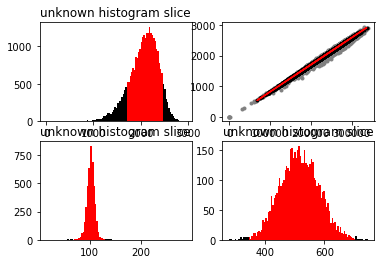

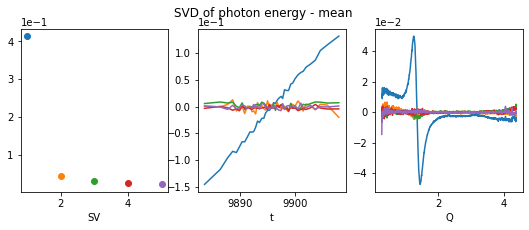

In [82]:
smalldata_folder='/reg/d/psdm/xcs/xcsly3420/hdf5/smalldata/smdffb/'
exper = 'xcsly3420'
runs=[120]
ReduceData(smalldata_folder,exper,runs,'/cds/home/s/slraj/code/ScatteringCode/',paramDict,outDict)

In [83]:
aa=np.load('/cds/home/s/slraj/code/ScatteringCode/xcsly3420_Run0120_out.npy',allow_pickle=True).item()

In [84]:
aa.keys()

dict_keys(['h5name', 'filters', 'normal_factor', 'loff_cake', 'xbin_occupancy', 'xcenter', 'xmean', 'xstd', 'diff_bin', 'diff_std', 'S0', 'S0_err', 'S2', 'S2_err', 'qs', 'phis', 'paramDict'])

# the plan

In [ ]:
#import packages and functions

#set up params dictionary: determine which functions/parameters will be called and used. 
#set up variable dictionary

#load h5 
    #for each detector load data
    #as process data delete variables from outDict
    
#IPM filterring and correlation filtering

#TT filtering

# set up scan variable

#calculate time delays (options for lxt, encoder only, tt corrections, etc)

#NL correction

#energy correction

#normalization of data and make cake? or option to normalize after binning? 
#(must normalize first if we want to use neighboring off shots for difference)
#make cake

#difference function - include different options

#bin function - include sum or mean and statistic information

#plot things

#svd options

#anisotropy options

#save data

In [ ]:
# for emmission/xray

#similar loading and filtering steps

#set up spectroscopy detector processing (set ADU thresholds)
    # droplet option
    
#process data


In [ ]:
# stack data
    #designate variables/detectors to stack and how 
    #(sum vs weighted average, vs average. . . vs bincount weighted)

#T<0 correction for data (noise floor)